In [186]:
import numpy as np
import scipy as sp
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import xarray as xr
import shapely
import rioxarray as rxr
import rasterio
from affine import Affine


In [187]:
precpFrame = pd.read_csv('datas/PRECIP/cn_precip.csv')
precpFrame.head()

,OBJECTID,FID_precipitation_Output_Features,lat,lon,1948,1949,1950,1951,1952,1953,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
0,1,405,18.375,109.125,1495.498,1744.171,2340.047,2585.415,1864.824,3053.427,...,1745.685,2550.323,2494.900,2063.530,3177.502,3106.839,3031.279,2157.478,2423.441,1491.074
1,2,406,18.375,109.375,1512.350,1750.608,2360.250,2597.892,1903.160,3094.233,...,1750.876,2568.117,2627.222,2160.359,3174.820,3149.657,3082.072,2216.498,2461.152,1529.851
2,3,407,18.375,109.625,1487.734,1689.226,2337.098,2555.251,1941.267,3081.161,...,1756.038,2494.818,2713.112,2130.966,3000.516,3080.358,2988.052,2222.123,2380.450,1556.578
3,4,660,18.625,108.875,1433.609,1715.874,2311.613,2588.235,1858.829,3076.461,...,1738.737,2498.925,2221.577,1683.219,3156.993,2926.329,2739.668,2106.235,2331.997,1824.250
4,5,661,18.625,109.125,1448.006,1691.064,2350.938,2595.576,1887.616,3096.594,...,1753.174,2509.489,2406.129,1830.306,3174.689,2983.378,2833.983,2183.503,2405.609,2269.238


In [188]:
latArr = sorted(precpFrame['lat'].unique())
lonArr = sorted(precpFrame['lon'].unique())


x经度lon，y纬度lat

In [189]:
precpSet = []
year = []
for i in range(2000,2016):
    year.append(i)
    a = precpFrame.pivot(index='lat', columns='lon', values=str(i))
    #a.sort_index(ascending=False, inplace=True)
    precpSet.append(a)

c=precpSet[0]

In [190]:
precipFrame = xr.Dataset(
    data_vars={
        'precip': (['year', 'y', 'x'], precpSet)
    },
    coords={'x': (['x'], lonArr),
            'y': (['y'], latArr),
            'year': year
            }

)
precipFrame.rio.write_crs(4326, inplace=True).rio.set_spatial_dims(x_dim="x",y_dim="y",inplace=True).rio.write_coordinate_system(inplace=True)

precipFrame


<xarray.Dataset>
Dimensions:      (year: 16, y: 140, x: 246)
Coordinates:
  * x            (x) float64 73.62 73.88 74.12 74.38 ... 134.1 134.4 134.6 134.9
  * y            (y) float64 18.38 18.62 18.88 19.12 ... 52.62 52.88 53.12 53.38
  * year         (year) int64 2000 2001 2002 2003 2004 ... 2012 2013 2014 2015
    spatial_ref  int64 0
Data variables:
    precip       (year, y, x) float64 nan nan nan nan nan ... nan nan nan nan

In [191]:

precipFrame.spatial_ref

<xarray.DataArray 'spatial_ref' ()>
array(0)
Coordinates:
    spatial_ref  int64 0
Attributes:
    crs_wkt:                      GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["...
    semi_major_axis:              6378137.0
    semi_minor_axis:              6356752.314245179
    inverse_flattening:           298.257223563
    reference_ellipsoid_name:     WGS 84
    longitude_of_prime_meridian:  0.0
    prime_meridian_name:          Greenwich
    geographic_crs_name:          WGS 84
    grid_mapping_name:            latitude_longitude
    spatial_ref:                  GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["...

<xarray.Dataset>
Dimensions:      (y: 140, x: 246)
Coordinates:
  * x            (x) float64 73.62 73.88 74.12 74.38 ... 134.1 134.4 134.6 134.9
  * y            (y) float64 18.38 18.62 18.88 19.12 ... 52.62 52.88 53.12 53.38
    year         int64 2015
    spatial_ref  int64 0
Data variables:
    precip       (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan


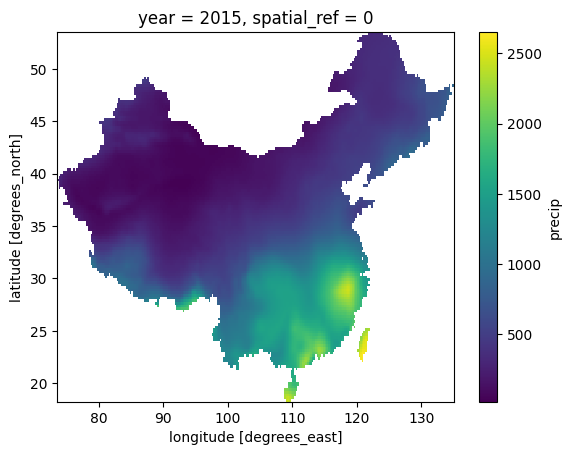

In [192]:
print(precipFrame.loc[dict(year=2015)])
precipFrame.loc[dict(year=2015)].precip.plot()

看一下标准的

In [193]:
tempFrame = xr.open_dataset(r"datas/TEMP/extracted/Temp_pred_2000_1_Tmean.tif").squeeze("band",drop=True)
tempFrame

<xarray.Dataset>
Dimensions:      (x: 6856, y: 4319)
Coordinates:
  * x            (x) float64 73.5 73.51 73.52 73.53 ... 135.1 135.1 135.1 135.1
  * y            (y) float64 53.56 53.55 53.54 53.54 ... 14.8 14.79 14.78 14.77
    spatial_ref  int64 ...
Data variables:
    band_data    (y, x) float32 ...

开切

In [194]:
cutBox = [114, 32, 121, 40]
cutFrame = shapely.geometry.box(*cutBox)

cutGdf = gpd.GeoDataFrame({'geometry': cutFrame}, index=[
                          0], crs={'init': 'epsg:4326'})
cutGdf.explore()


/home/zyzh0/anaconda3/envs/gis/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [195]:
precipCutted = precipFrame.rio.clip(cutGdf.geometry,crs=precipFrame.rio.crs)

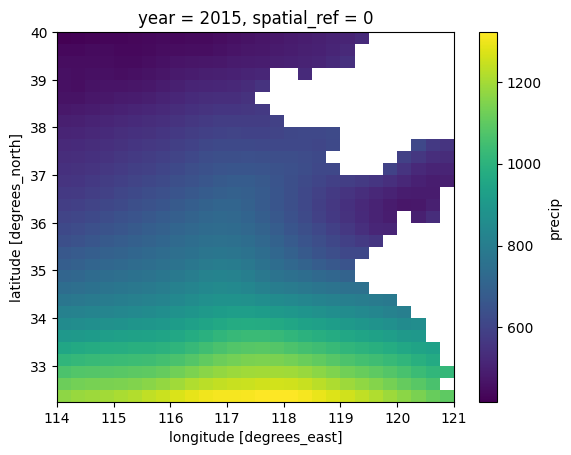

In [197]:
precipCutted.loc[dict(year=2015)].precip.plot()